In [1]:
%load_ext autoreload 
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np 
from pvec_functions import * 
from fabber_funcs import get_fabber_data, run_oxasl, MODEL_OPTIONS, PARAMS
np.random.seed(1)
def get_fig(size=(15,5), dpi=100, **kwargs): 
    return plt.figure(figsize=size, dpi=dpi, **kwargs)

In [2]:
asl_spc = rt.ImageSpace.create_axis_aligned([0,0,0], [15,15,15], [4,4,4])
mid_slice = asl_spc.size[-1] // 2

In [3]:
R_g = 25
R_w = 22
superfactor = 10
sph_cent = asl_spc.fov_size / 2
pvs_asl = calc_sphere_pvs(sph_cent, R_g, R_w, asl_spc, superfactor)
make_mask = lambda a: (a > 0.02).all(-1)
mask_asl = make_mask(pvs_asl)
brain_mask = (pvs_asl > 0.02).any(-1)

# BASIL PVEc problems

GM and WM are differentiated by their CBF and BAT. 
To simulate data with PVE, we call fabber twice with 100% GM and 100% WM voxels respectively, and then mix these two values according to voxel-wise PVE. 

In [4]:
CBF = [PARAMS['GM_CBF'], PARAMS['WM_CBF']]
BAT = [PARAMS['GM_BAT'], PARAMS['WM_BAT']]
print(CBF, BAT)

[60, 20] [1.3, 1.6]


## 1 repeat per PLD, both lambda = 0.9, allow inference of BAT with SD = 1e-6

In [5]:
opts = {**MODEL_OPTIONS, 'repeats': 1, 'batsd': 1e-6}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 0.9,
 'lambdawm': 0.9,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06,
 'pvcorr': True,
 't1wm': 1.3,
 'repeats': 1}

In [6]:
asl = get_fabber_data(CBF, BAT, pvs_asl, opts)
cbf = run_oxasl(asl, brain_mask, opts)
cbf_pvec = run_oxasl(asl, brain_mask, opts, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl --rpts=1 -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06
basil options: lambda=0.9 lambdawm=0.9 --t1wm=1.3  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl --rpts=1 -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz
basil options: lambda=0.9 lambdawm=0.9 --t1wm=1.3  




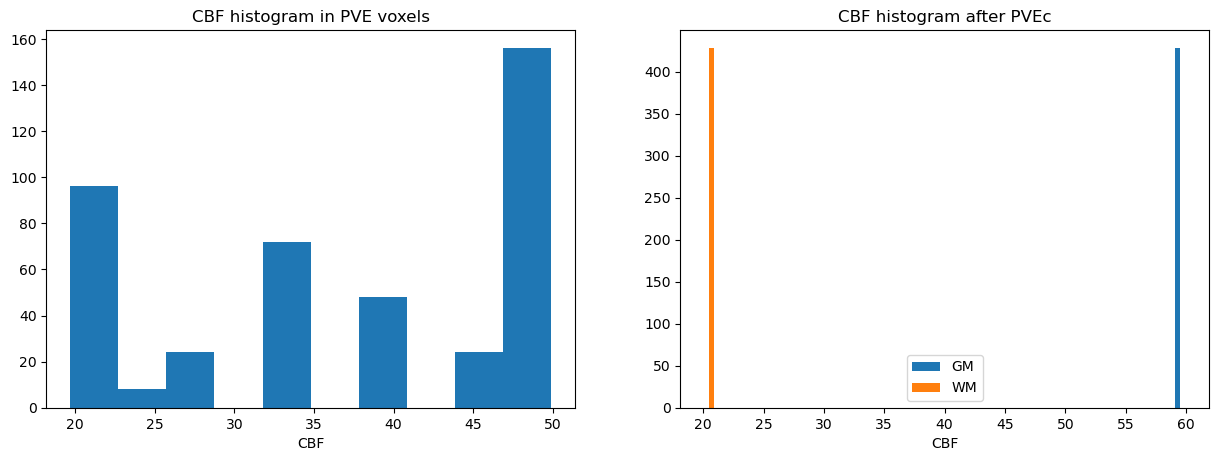

[60.00050625 19.99970953]


In [7]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()
print(cbf_pvec[mask_asl].mean(0))

This is now exactly correct. 

## 5 repeats per PLD, both lambda = 0.9, allow inference of BAT with SD = 1e-6

In [8]:
opts = {**MODEL_OPTIONS, 'repeats': 5, 'batsd': 1e-6}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 0.9,
 'lambdawm': 0.9,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06,
 'pvcorr': True,
 't1wm': 1.3,
 'repeats': 5}

In [9]:
asl = get_fabber_data(CBF, BAT, pvs_asl, opts)
# asl += np.random.normal(0,0.5, size=asl.shape)   # optional: add a small amount of noise. 
cbf = run_oxasl(asl, brain_mask, opts)
cbf_pvec = run_oxasl(asl, brain_mask, opts, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl --rpts=5 -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06
basil options: lambda=0.9 lambdawm=0.9 --t1wm=1.3  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl --rpts=5 -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz
basil options: lambda=0.9 lambdawm=0.9 --t1wm=1.3  




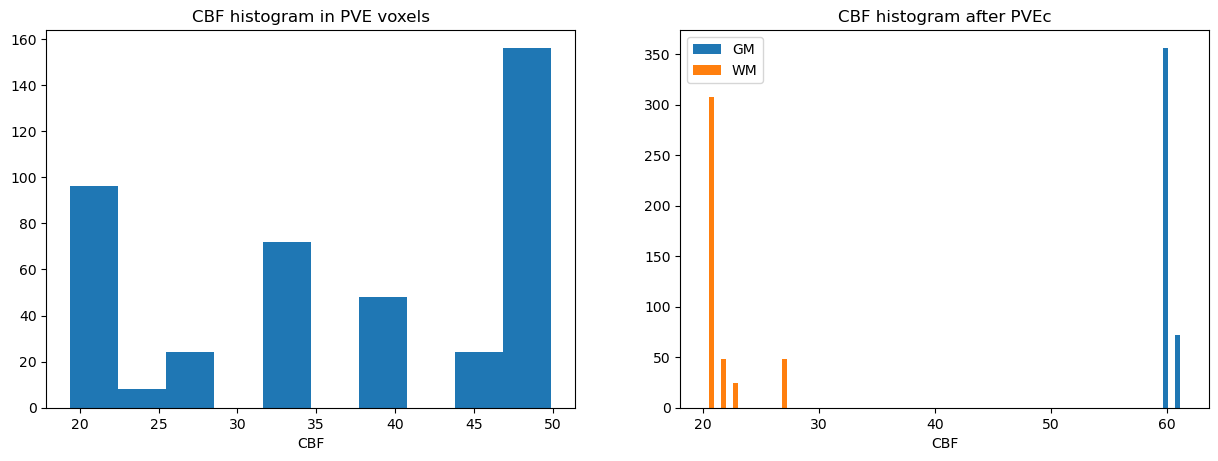

[60.28170031 21.12811142]


In [10]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()
print(cbf_pvec[mask_asl].mean(0))

# Dont run past this point. 

## 1 repeat per PLD, both lambda = 0.9, fix BAT for each tissue

In [11]:
opts = {**MODEL_OPTIONS, 'repeats': 1}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 1,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 0.9,
 'lambdawm': 0.9,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06}

In [12]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, {**opts, **PARAMS})
cbf_pvec = run_oxasl(asl, brain_mask, {**opts, **PARAMS}, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --fixbat
basil options: lambda=0.9 lambdawm=0.9 batwm=1.6 bat=1.3  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz --fixbat
basil options: lambda=0.9 lambdawm=0.9 batwm=1.6 bat=1.3  




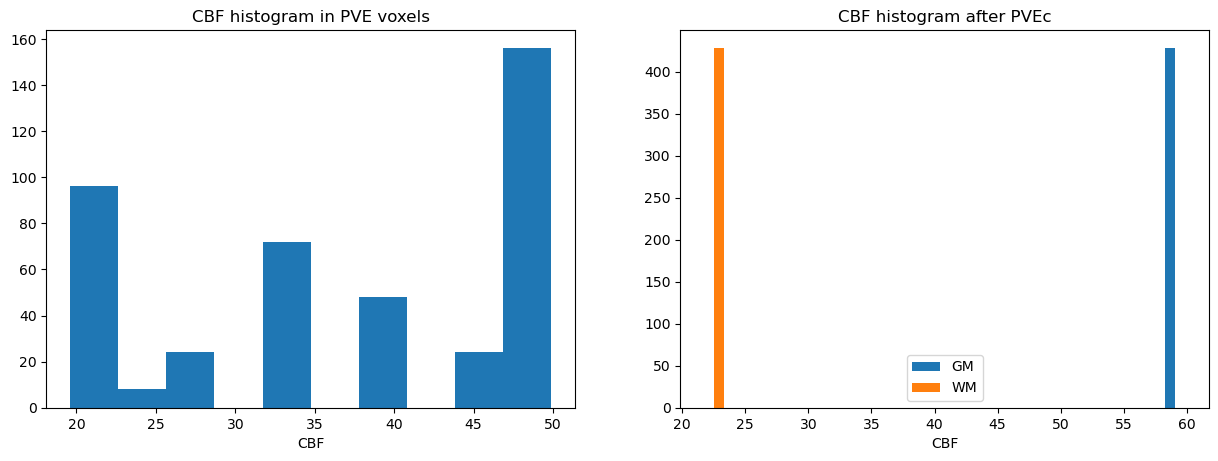

In [13]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

This performs the same as for 1 repeat per PLD, both lambda = 0.9, infer BAT with SD = 1e-6. Ie, when we constrain the inference of BAT tightly, it gets the same solution as when we simply give the BAT explicitly. 

## 5 repeats per PLD, both lambda = 0.9, fix BAT for each tissue

In [14]:
opts = {**MODEL_OPTIONS, 'repeats': 5}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 5,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 0.9,
 'lambdawm': 0.9,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06}

In [15]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, {**opts, **PARAMS})
cbf_pvec = run_oxasl(asl, brain_mask, {**opts, **PARAMS}, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --fixbat
basil options: lambda=0.9 lambdawm=0.9 batwm=1.6 bat=1.3  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz --fixbat
basil options: lambda=0.9 lambdawm=0.9 batwm=1.6 bat=1.3  




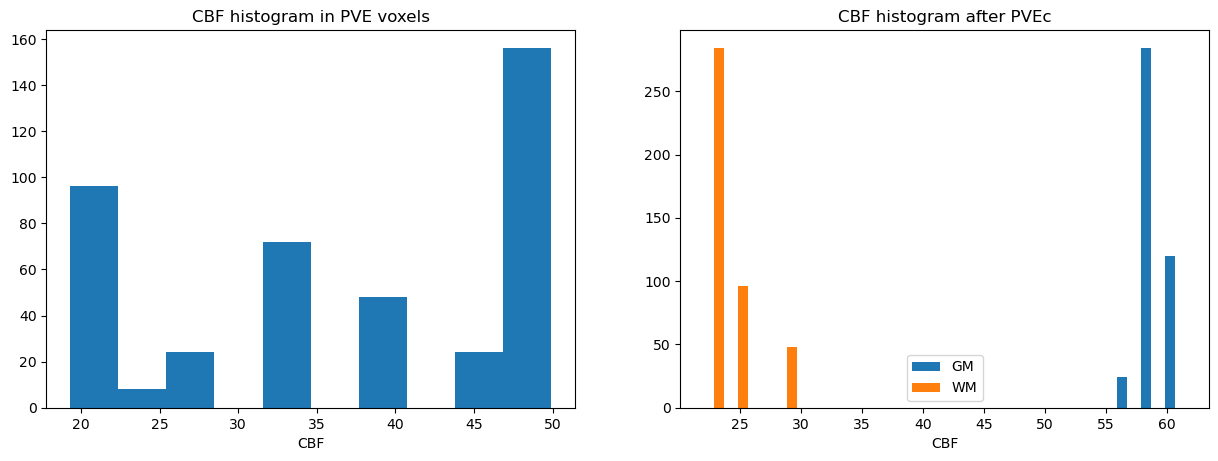

In [16]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

This performs the same as for 5 repeats per PLD, both lambda = 0.9, infer BAT with SD = 1e-6. Ie, when we constrain the inference of BAT tightly, it gets the same solution as when we simply give the BAT explicitly. 

## 1 repeat per PLD, set both lambda = 1, fix BAT for each tissue  

In [17]:
opts = {**MODEL_OPTIONS, 'repeats': 1, 'lambda': 1, 'lambdawm': 1}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 1,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 1,
 'lambdawm': 1,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06}

In [18]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, {**opts, **PARAMS})
cbf_pvec = run_oxasl(asl, brain_mask, {**opts, **PARAMS}, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --fixbat
basil options: lambda=1 lambdawm=1 batwm=1.6 bat=1.3  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz --fixbat
basil options: lambda=1 lambdawm=1 batwm=1.6 bat=1.3  




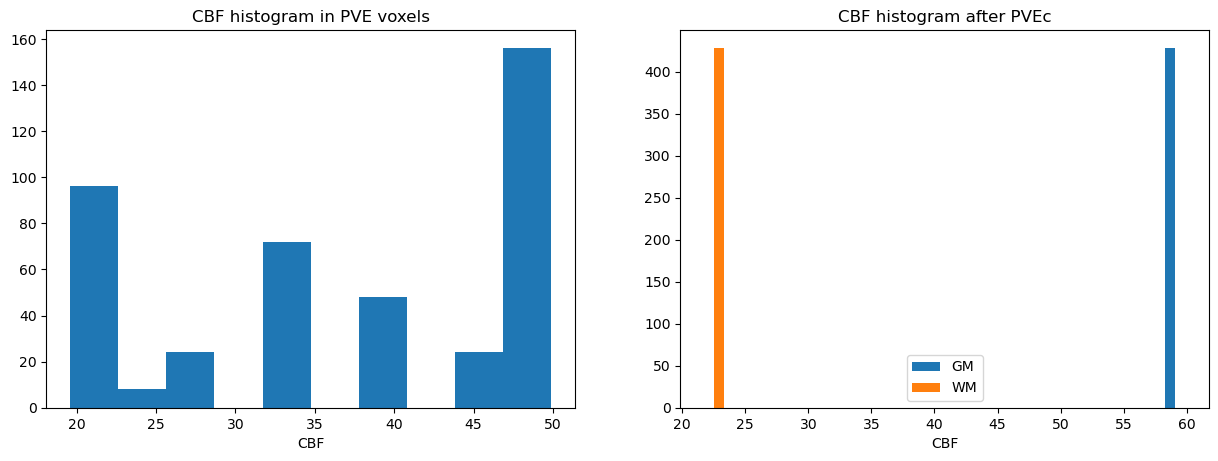

In [19]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

I was hoping that changing the lambda value would correct the small offset between the PVEc results and ground truth: why is WM slightly too large, and GM slightly too small? When we set both lambda to 1 no change is observed compared to having them both 0.9. 

## 5 repeats per PLD, set both lambda = 1, fix BAT for each tissue  

In [20]:
opts = {**MODEL_OPTIONS, 'repeats': 5, 'lambda': 1, 'lambdawm': 1}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 5,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 1,
 'lambdawm': 1,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06}

In [21]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, {**opts, **PARAMS})
cbf_pvec = run_oxasl(asl, brain_mask, {**opts, **PARAMS}, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --fixbat
basil options: lambda=1 lambdawm=1 batwm=1.6 bat=1.3  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz --fixbat
basil options: lambda=1 lambdawm=1 batwm=1.6 bat=1.3  




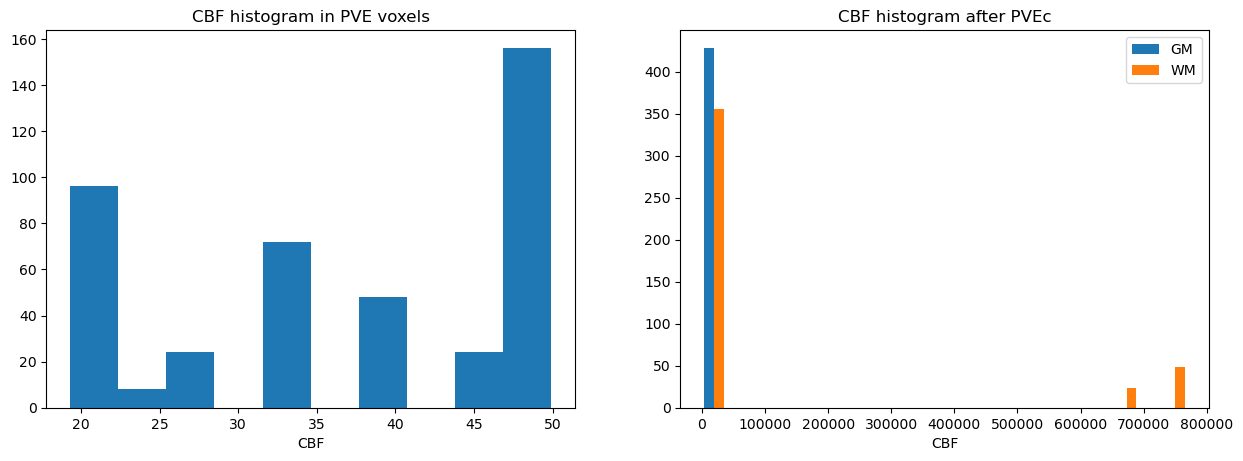

In [22]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

In [23]:
print(cbf_pvec[mask_asl].mean(0))

[5.98866652e+01 1.23653975e+05]


This is the first clear example of instability: we have multiple repeats, both lambda = 1, and the BAT has been fixed. The GM results are very close to correct (on average), the WM is wrong all round. Even the small values in WM are in fact larger than GM. 

## 1 repeat per PLD, set both lambda = 1, allow inference of BAT with SD = 1e-6

In [24]:
opts = {**MODEL_OPTIONS, 'repeats': 1, 'lambda': 1, 'lambdawm': 1}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 1,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 1,
 'lambdawm': 1,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06}

In [25]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, opts)
cbf_pvec = run_oxasl(asl, brain_mask, opts, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06
basil options: lambda=1 lambdawm=1  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz
basil options: lambda=1 lambdawm=1  




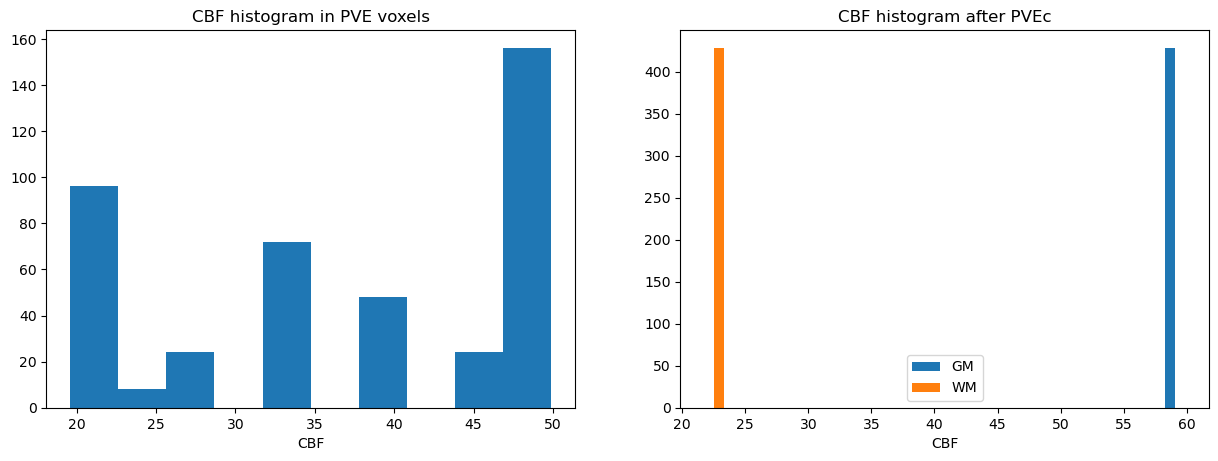

In [26]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

This looks to be the same as the equivalent case with BAT fixed: single repeat per PLD, both lambda = 1, BAT tightly constrained gives an answer that is stable (but wrong). 

## 5 repeats per PLD, set both lambda = 1, allow inference of BAT with SD = 1e-6

In [27]:
opts = {**MODEL_OPTIONS, 'repeats': 5, 'lambda': 1, 'lambdawm': 1}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 5,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 1,
 'lambdawm': 1,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06}

In [28]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, opts)
cbf_pvec = run_oxasl(asl, brain_mask, opts, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06
basil options: lambda=1 lambdawm=1  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz
basil options: lambda=1 lambdawm=1  




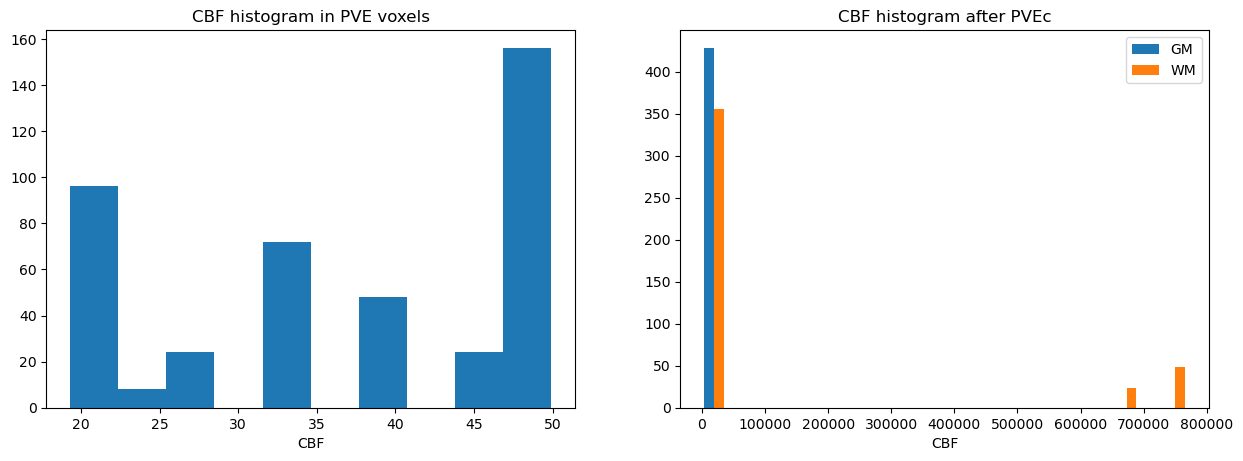

In [29]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

This also looks to be the same as the equivalent case with BAT fixed: either way, multiple repeats with both lambda = 1 gives unstable WM results for both fixed or tightly constrained BAT

## 1 repeat per PLD, set both lambda = 1, allow inference of BAT with SD = 1

In [30]:
opts = {**MODEL_OPTIONS, 'repeats': 1, 'lambda': 1, 'lambdawm': 0.9, 'batsd': 1}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 1,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 1,
 'lambdawm': 0.9,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1}

In [31]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, opts)
cbf_pvec = run_oxasl(asl, brain_mask, opts, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1
basil options: lambda=1 lambdawm=0.9  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz
basil options: lambda=1 lambdawm=0.9  




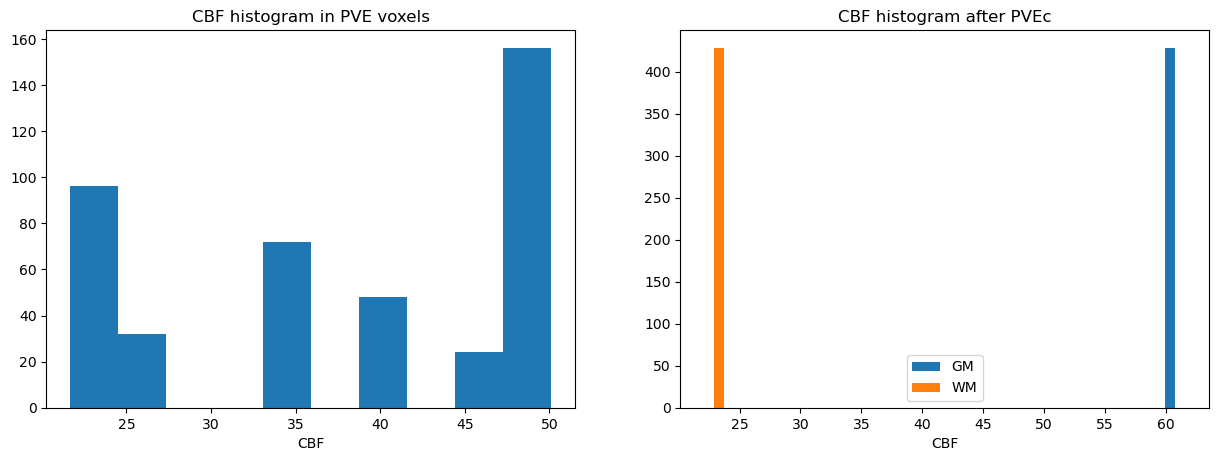

In [32]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

If we relax the constraint on BAT compared to having it tightly bound, it seems to make a small improvement in GM (before it was slightly too small, whereas now it is in the right place). WM does not seem to change however. This does suggest that the BAT in GM has moved somewhat, which is not the correct solution. 

## 5 repeats per PLD, set both lambda = 1, allow inference of BAT with SD = 1

In [33]:
opts = {**MODEL_OPTIONS, 'repeats': 5, 'lambda': 1, 'lambdawm': 0.9, 'batsd': 1}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 5,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 1,
 'lambdawm': 0.9,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1}

In [34]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, opts)
cbf_pvec = run_oxasl(asl, brain_mask, opts, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1
basil options: lambda=1 lambdawm=0.9  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz
basil options: lambda=1 lambdawm=0.9  




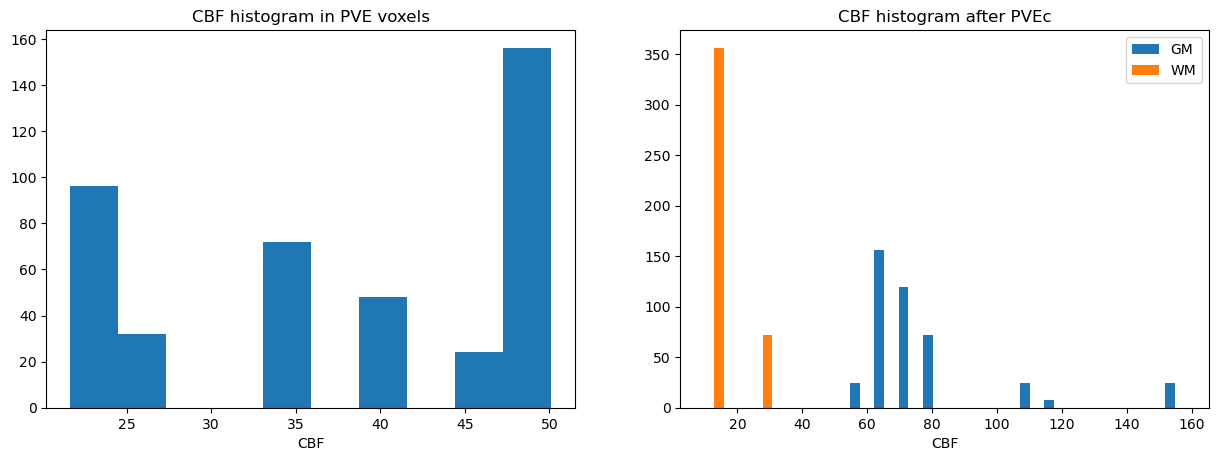

In [35]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

If we relax the constraint on BAT, it does seeem to vastly reduce the instability we observed on the multiple repeat, lambda = 1 case. However, it stands to reason we will simply have achieved this by letting the BAT vary across voxels, which is obviously the wrong solution. 

## 1 repeat per PLD, set lambda = 1, lambdawm = 0.9, allow inference of BAT with SD = 1e-6

In [36]:
opts = {**MODEL_OPTIONS, 'repeats': 1, 'lambda': 1, 'lambdawm': 1}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 1,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 1,
 'lambdawm': 1,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06}

In [37]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, opts)
cbf_pvec = run_oxasl(asl, brain_mask, opts, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06
basil options: lambda=1 lambdawm=1  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz
basil options: lambda=1 lambdawm=1  




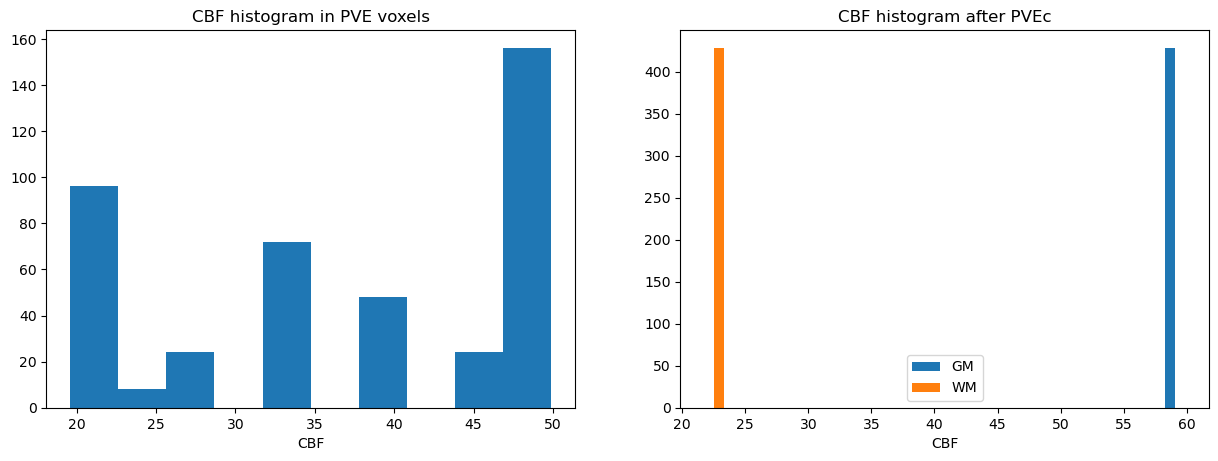

In [38]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

This time, we allow for a small difference in lambda between tissues and constrain BAT again. This looks to perform the same as the case when both lambda = 1: its almost correct, but a bit off. 

## 5 repeats per PLD, set lambda = 1, lambdawm = 0.9, allow inference of BAT with SD = 1e-6

In [39]:
opts = {**MODEL_OPTIONS, 'repeats': 5, 'lambda': 1, 'lambdawm': 0.9}
opts

{'model': 'aslrest',
 'pld1': 1.25,
 'pld2': 1.5,
 'pld3': 1.75,
 'pld4': 2,
 'pld5': 2.25,
 'repeats': 5,
 'tau': 1,
 'casl': True,
 'inctiss': True,
 'incbat': True,
 'alpha': 1,
 'lambda': 1,
 'lambdawm': 0.9,
 't1': 1.3,
 't1b': 1.65,
 'batsd': 1e-06}

In [ ]:
asl = ((get_fabber_data(PARAMS['GM_CBF'], PARAMS['GM_BAT'], asl_spc.size, opts) * pvs_asl[...,0,None]) 
      + ((get_fabber_data(PARAMS['WM_CBF'], PARAMS['WM_BAT'], asl_spc.size, opts) * pvs_asl[...,1,None])))
cbf = run_oxasl(asl, brain_mask, opts)
cbf_pvec = run_oxasl(asl, brain_mask, opts, pvs_asl)

oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06
basil options: lambda=1 lambdawm=0.9  


oxasl --iaf=diff --overwrite --no-report --artoff --fixbolus --ibf=tis --basil-options=tempdir/basil_opts.txt --t1=1.3 --t1b=1.65 --alpha=1 --casl  -i tempdir/data.nii.gz -o tempdir/oxasl_out -m tempdir/mask.nii.gz --debug  --tau=1  --plds=1.25,1.5,1.75,2,2.25 --batsd=1e-06 --pvcorr --pvgm=tempdir/pvgm.nii.gz --pvwm=tempdir/pvwm.nii.gz
basil options: lambda=1 lambdawm=0.9  




In [ ]:
fig = get_fig()
plt.subplot(1,2,1)
plt.hist(cbf[mask_asl])
plt.title('CBF histogram in PVE voxels'); plt.xlabel('CBF')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask_asl], 40)
plt.title('CBF histogram after PVEc'); plt.xlabel('CBF')
plt.legend(['GM', 'WM'])
plt.show()

Strangely, although multiple repeats with both lambda = 0.9 and BAT fixed performed pretty badly, and then with both lambda = 1 performed much worse (the first example of instability), reducing lambdawm and keeping the tight constraint on BAT does not seem to correct the instability. 

## Summary

- with both lambda = 1 and BAT fixed, multiple repeats is unstable, whereas single repeats is not (but is nevertheless wrong)
- multiple repeats seems to be strictly worse - unstable - than single repeat, for any configuration 
- with single repeat, allowing a difference in lambda doesn't seem to make a difference compared to having them both the same 
- with multiple repeats, having both lambda = 0.9 is pretty bad, both = 1 is terrible, and letting them differ is also terrible
- using BAT SD = 1e-6 does give the desired effect of steering BAT to the correct values, and setting --fixbat explicitly also has been confirmed to work 
- relaxing the BAT constraint for an unstable configuration does help, but presumably just because the variability is being taken up in BAT values instead of CBF. 
- for the cases that are 'almost correct', changing both lambda values doesn't do anything: as exepcted, this variable seems to cancel itself out during data generation and then inference. 